In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Permute,  Reshape,  Lambda, Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply


SINGLE_ATTENTION_VECTOR = False


def attention_conv_block(inputs,timesteps):
    varsVec=[]
    for x in range(0,inputs.shape[2]):
            var=Lambda(lambda element : element[:,:,x])(inputs)
            var=contxt_padded = Lambda(lambda x: K.expand_dims(x,2))(var)
            var = Conv1D(filters=5 ,kernel_size=3,strides=1,padding='same',name='conv2_%d' % x)(var)
            var = Conv1D(filters=1 ,kernel_size=3,strides=1,padding='same',activation='softmax',name='conv_final_softmax_%d' % x)(var)
            varsVec.append(var)
    
    merged = concatenate(varsVec)
    output_attention_mul= Multiply()([inputs, merged])
    return output_attention_mul


class LSTMATTBFnet:
    @staticmethod
    def build(timeSteps,variables,classes):
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        #attBlock=attention_conv_block(inputNet,timeSteps)
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True
        lstm=Bidirectional(LSTM(100,recurrent_dropout=0.1,dropout=0.1,return_sequences=False),merge_mode='concat')(inputNet) #worse using stateful=True 
        
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(lstm)
        
        model=Model(inputNet,classificationLayer)
        return model


/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split


def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,72,8))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
#train_inputs, test_inputs, train_output, test_output = train_test_split(total_inputs, total_output, test_size=0.20, random_state=42)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)





############# total shapes #############
(2876, 72, 8)
2876
############# train shapes #############
(2301, 72, 8)
(2301, 1)
############# test shapes #############
(575, 72, 8)
(575, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = LSTMATTBFnet.build(timeSteps=72,variables=8,classes=5)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(575, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 8)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               87200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 88,205
Trainable params: 88,205
Non-trainable params: 0
_________________________________________________________________


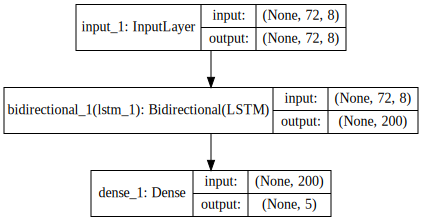

In [4]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt

modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)
plot_model(model, to_file='model-att-conv1d.pdf',show_shapes=True)


In [5]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('LSTM-polution.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Train on 2301 samples, validate on 575 samples
Epoch 1/100
2301/2301 [==============================] - 10s 4ms/step - loss: 1.5488 - acc: 0.2864 - val_loss: 1.4879 - val_acc: 0.2817

Epoch 00001: val_acc improved from -inf to 0.28174, saving model to LSTM-polution.h5
Epoch 2/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.4514 - acc: 0.3559 - val_loss: 1.4860 - val_acc: 0.3043

Epoch 00002: val_acc improved from 0.28174 to 0.30435, saving model to LSTM-polution.h5
Epoch 3/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.4332 - acc: 0.3629 - val_loss: 1.4407 - val_acc: 0.3217

Epoch 00003: val_acc improved from 0.30435 to 0.32174, saving model to LSTM-polution.h5
Epoch 4/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.4141 - acc: 0.3698 - val_loss: 1.4420 - val_acc: 0.3391

Epoch 00004: val_acc improved from 0.32174 to 0.33913, saving model to LSTM-polution.h5
Epoch 5/100
2301/2301 [==============================] - 8s

2301/2301 [==============================] - 8s 4ms/step - loss: 1.3134 - acc: 0.4276 - val_loss: 1.3378 - val_acc: 0.3965

Epoch 00042: val_acc did not improve from 0.42087
Epoch 43/100
2301/2301 [==============================] - 8s 4ms/step - loss: 1.3179 - acc: 0.4316 - val_loss: 1.3368 - val_acc: 0.3983

Epoch 00043: val_acc did not improve from 0.42087
Epoch 44/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.3080 - acc: 0.4233 - val_loss: 1.3352 - val_acc: 0.4052

Epoch 00044: val_acc did not improve from 0.42087
Epoch 45/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.3092 - acc: 0.4268 - val_loss: 1.3372 - val_acc: 0.4122

Epoch 00045: val_acc did not improve from 0.42087
Epoch 46/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.3093 - acc: 0.4263 - val_loss: 1.3374 - val_acc: 0.4052

Epoch 00046: val_acc did not improve from 0.42087
Epoch 47/100
2301/2301 [==============================] - 8s 3ms/step - loss: 

2301/2301 [==============================] - 8s 3ms/step - loss: 1.3014 - acc: 0.4346 - val_loss: 1.3354 - val_acc: 0.4035

Epoch 00086: val_acc did not improve from 0.42087
Epoch 87/100
2301/2301 [==============================] - 8s 4ms/step - loss: 1.2960 - acc: 0.4363 - val_loss: 1.3399 - val_acc: 0.3913

Epoch 00087: val_acc did not improve from 0.42087
Epoch 88/100
2301/2301 [==============================] - 8s 4ms/step - loss: 1.2977 - acc: 0.4385 - val_loss: 1.3407 - val_acc: 0.3896

Epoch 00088: val_acc did not improve from 0.42087
Epoch 89/100
2301/2301 [==============================] - 8s 3ms/step - loss: 1.2970 - acc: 0.4398 - val_loss: 1.3334 - val_acc: 0.4000

Epoch 00089: val_acc did not improve from 0.42087
Epoch 90/100
2301/2301 [==============================] - 8s 4ms/step - loss: 1.3020 - acc: 0.4276 - val_loss: 1.3371 - val_acc: 0.3843

Epoch 00090: val_acc did not improve from 0.42087
Epoch 91/100
2301/2301 [==============================] - 8s 3ms/step - loss: 

In [7]:
import json,codecs
import numpy as np
def saveHist(path,history):
 
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           #if  type(history.history[key][0]) == np.float64:
           new_hist[key] = list(map(float, history.history[key]))
 
    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
 
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n
 


saveHist('LSTM-polution.hist',history)
hist=loadHist('LSTM-polution.hist')




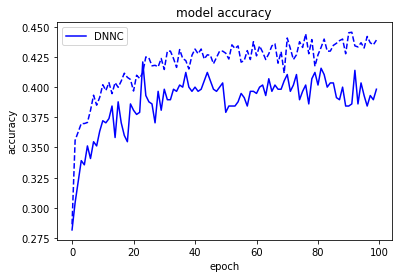

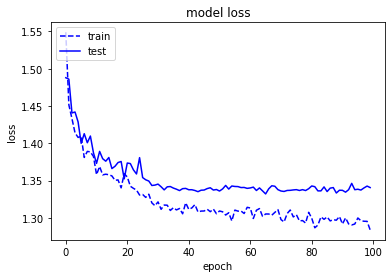

In [9]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import load_model
model = load_model('LSTM-polution.h5')

print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)

Confusion Matrix
[[70 36  2  5  2]
 [24 74 12 25  7]
 [13 47 30 34 16]
 [ 4 26 10 41 27]
 [ 3 15  4 21 27]]
Dados Validação acc: 42.09%
             precision    recall  f1-score   support

          0     0.6140    0.6087    0.6114       115
          1     0.3737    0.5211    0.4353       142
          2     0.5172    0.2143    0.3030       140
          3     0.3254    0.3796    0.3504       108
          4     0.3418    0.3857    0.3624        70

avg / total     0.4438    0.4209    0.4135       575



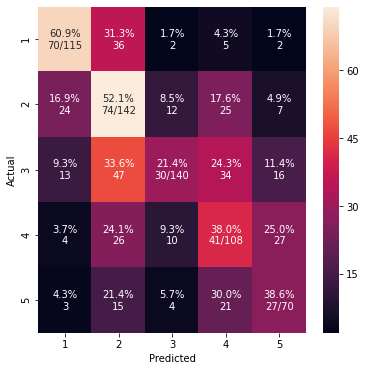

In [13]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("LSTM-ATTENTION-CONV1D-AF-BIDIRECT-SPLIT-polution-CM.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(6,6))